# Demo trace amplitude

author: laquitainesteeve@gmail.com

Purpose: describe trace amplitudes

Execution time: 2 min

## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath_evoked = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'
filepath_spont = 'sub-demo-npx-bio-spont/sub-demo-npx-bio-spont_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
# proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import amplitude as amp

# evoked demo
cfg_e, param_cfg_e = get_config("silico_neuropixels", "npx_evoked").values() # config
FREQ_MIN_E = param_cfg_e["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_E = param_cfg_e["run"]["preprocessing"]["max_filter_freq"]

# spontaneous demo
cfg_s, param_cfg_s = get_config("silico_neuropixels", "npx_spont").values() # config
FREQ_MIN_S = param_cfg_s["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_S = param_cfg_s["run"]["preprocessing"]["max_filter_freq"]

# plot parameters
FIG_SIZE = (1.5, 1)
COLOR_NE = [1, 0.49, 0]
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame
savefig_cfg = {"transparent":True, "dpi": 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-05 14:53:38,594 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-05 14:53:38,880 - root - utils.py - get_config - INFO - Reading experiment config. - done
2025-04-05 14:53:39,086 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-05 14:53:39,272 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 8
available gpus: False


['/bin/bash: free: command not found']

## (.3s)Load demos

* first 10 minutes of recordings for speed

In [29]:
%%time

# parameters
LYRS = ["L5", "L6"]

# EVOKED DEMO ---------------------------------------------

# download the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_evoked)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingE = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")

# preprocess
# - compress to int16 (like the Kilosort sorters)
# - apply band-pass filter and common referencing
RecordingE = spre.astype(RecordingE, "int16")
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN_E, freq_max=FREQ_MAX_E)
RecordingE = spre.common_reference(RecordingE, reference="global", operator="median")

# get traces and standardized layer names
traces_ne = RecordingE.get_traces()
site_ly_ne = RecordingE.get_property("layers")
site_ly_ne = standardize_layers(site_ly_ne)
sites_ne = np.where(np.isin(site_ly_ne, LYRS))[0]

# SPONTANEOUS DEMO ---------------------------------------------

# download the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_spont)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingS = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")

# preprocess
# - compress to int16 (like the Kilosort sorters)
# - apply band-pass filter and common referencing
RecordingS = spre.astype(RecordingS, "int16")
RecordingS = spre.bandpass_filter(RecordingS, freq_min=FREQ_MIN_S, freq_max=FREQ_MAX_S)
RecordingS = spre.common_reference(RecordingS, reference="global", operator="median")

# get traces and standardized layer names
traces_ns = RecordingS.get_traces()
site_ly_ns = RecordingS.get_property("layers")
site_ly_ns = standardize_layers(site_ly_ns)
sites_ns = np.where(np.isin(site_ly_ns, LYRS))[0]

CPU times: user 1min 20s, sys: 27.9 s, total: 1min 48s
Wall time: 4min 43s


## Compute

The expected max absolute amplitude is about 387 uV in the full 1-hour trace.

In [ ]:
%%time 

# maximum per site
maxs_ns = np.absolute(traces_ns[:, sites_ns]).max(axis=0)
maxs_ne = np.absolute(traces_ne[:, sites_ne]).max(axis=0)

# make dataframe
df2 = pd.DataFrame()
df2["amplitude"] = maxs_ns
df2["layer"] = np.array(site_ly_ns)[sites_ns]
df2["experiment"] = "spont"
df2 = df2.sort_values(by=["layer"])

df3 = pd.DataFrame()
df3["amplitude"] = maxs_ne
df3["layer"] = np.array(site_ly_ne)[sites_ne]
df3["experiment"] = "evoked"
df3 = df3.sort_values(by=["layer"])

# stack
plot_data = pd.concat([df2, df3])
plot_data = plot_data.sort_values(by=["experiment", "layer"])
display(plot_data)

# report info 
print("Spont extremum:", np.max(np.absolute(traces_ns)))
print("Evoked extremum:", np.max(np.absolute(traces_ne)))

# unit-test
layers = ["L5", "L6"]
assert df2["layer"].unique().tolist() == layers, "wrong layers"
assert df3["layer"].unique().tolist() == layers, "wrong layers"

,amplitude,layer,experiment
59,81,L5,evoked
80,83,L5,evoked
79,48,L5,evoked
78,91,L5,evoked
77,361,L5,evoked
...,...,...,...
64,17,L6,spont
63,25,L6,spont
62,31,L6,spont
68,23,L6,spont


Spont extremum: 324
Evoked extremum: 361


## Plot

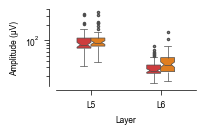

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1));

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="amplitude",
    hue="experiment",
    notch=True,
    hue_order=[
        "spont", "evoked",
    ],
    palette=[cl["COLOR_NS"], cl["COLOR_NE"]],
    width=0.4,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
);

ax.set_yscale("log");

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
);
ax.tick_params(which="both");
ax.yaxis.set_minor_locator(locmin);

# axes
ax.spines[["top", "right"]].set_visible(False);
ax.legend("", frameon=False);

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05));
ax.yaxis.set_ticks_position("left");
ax.spines["left"].set_position(("axes", -0.05));

# ax.legend("", frameon=False)
ax.set_ylabel("Amplitude (\u03bcV)");
ax.set_xlabel("Layer");
ax.set_ylim([0, 400]);

## Statistics

### Peak amplitude changes across layers?

kruskal-Wallis H statistic corresponds to the $\chi^2$ value

Dunn's test

In [15]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record
    

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
print("\n--------------------E--------------------\n")
amp.get_kk_demo(plot_data, "evoked")
amp.get_posthoc_dunn_holm_sidak_demo(plot_data, "evoked")
m_e = get_medians_and_ci95(plot_data, "evoked", "amplitude")  


--------------------E--------------------

H=73.85343096181766, p=8.413803677307674e-18
N_L5 = 52 sites
N_L6 = 68 sites
91.0 $\pm$ 16.72112, 34.0 $\pm$ 4.901311, 


# Are Models and in vivo data the same?

In [22]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_amplitude(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["amplitude"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_amplitude(df, "spont", layer),
        get_amplitude(df, "evoked", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N= {count_sites(df, "spont", layer)} sites""")
    print(f"""N = {count_sites(df, "evoked", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "spont", layer),
        get_amplitude(plot_data, "evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["spont", "evoked"]
    df.index = ["spont", "evoked"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "spont", layer),
        get_amplitude(plot_data, "evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["spont", "evoked"]
    df.index = ["spont", "evoked"]
    return df

In [23]:
# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the amplitudes that significantly deviate from others
print("\n------LAYER 5:------\n")
get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")
get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))


------LAYER 5:------

H=1.123621446555255, p=0.28913999707252735
N= 52 sites
N = 52 sites


,spont,evoked
spont,1.00000,0.28914
evoked,0.28914,1.00000



------LAYER 6:------

H=7.279522411047727, p=0.006974507669614558
N= 68 sites
N = 68 sites


,spont,evoked
spont,1.000000,0.006975
evoked,0.006975,1.000000


### H3: Do the spont. model and M-S amplitudes differ? OFTEN.

In [26]:
print("\nlayer 5\n")
amp.get_mwu(plot_data, "evoked", "spont", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "evoked", "spont", "L6")


layer 5

1 vs. 2, z=1515.0, p=0.2920934571238412, N_1=52, N_2=52

layer 6

1 vs. 2, z=2931.5, p=0.006831355266259868, N_1=68, N_2=68


### H4: Do evoked model and M-S amplitudes differ? YES?

In [28]:
print("\nlayer 5\n")
amp.get_mwu(plot_data, "spont", "evoked", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "spont", "evoked", "L6")


layer 5

1 vs. 2, z=1189.0, p=0.2920934571238412, N_1=52, N_2=52

layer 6

1 vs. 2, z=1692.5, p=0.006831355266259868, N_1=68, N_2=68
